Seattle Rainfall Prediction


In [ ]:
import numpy as np
import pandas as pd
import collections
import random
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import seaborn as sns
from tabulate import tabulate
from IPython.display import display
import warnings
%matplotlib inline

warnings.filterwarnings("ignore", category=UserWarning)

dpi_value = 125

We'll be analyzing a time series dataset spanning from 1948 to 2017. The dataset includes the following weather metrics:

- **date**: The date associated with the weather measurements.
- **prcp**: Precipitation in inches.
- **tmax**: Maximum temperature in Fahrenheit.
- **tmin**: Minimum temperature in Fahrenheit.
- **rain**: A binary indicator representing whether it rained or not on a given day.

This dataset will be used for our analysis.

In [ ]:
weather_df = pd.read_csv("seattleWeather_1948-2017.csv", parse_dates=True)
weather_df.columns = map(str.lower, weather_df.columns)
weather_df = weather_df.squeeze(axis=1)

display(weather_df.head())


,date,prcp,tmax,tmin,rain
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [ ]:
weather_df.shape

(25551, 5)

In [ ]:
display(weather_df.dtypes.to_frame().rename(columns={0: 'Data Type'}))

,Data Type
date,object
prcp,float64
tmax,int64
tmin,int64
rain,object


In [ ]:
display(weather_df.describe())

,prcp,tmax,tmin
count,25548.000000,25551.000000,25551.000000
mean,0.106222,59.544206,44.514226
std,0.239031,12.772984,8.892836
min,0.000000,4.000000,0.000000
25%,0.000000,50.000000,38.000000
50%,0.000000,58.000000,45.000000
75%,0.100000,69.000000,52.000000
max,5.020000,103.000000,71.000000


###Data Cleaning:

We will perform the following steps to clean the dataset:

Convert Date Column: We will convert the 'date' column to a datetime object to facilitate time-based analysis.

Add Date Features: We will extract additional features from the date column that might be useful for analysis later on.

In [ ]:
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['day'] = [d.day for d in weather_df.date]
weather_df['month'] = [d.month for d in weather_df.date]
weather_df['year'] = [d.year for d in weather_df.date]
weather_df = weather_df[['date', 'year', 'month', 'day', 'prcp', 'tmax', 'tmin', 'rain']]
display(weather_df.head())

,date,year,month,day,prcp,tmax,tmin,rain
0,1948-01-01,1948,1,1,0.47,51,42,True
1,1948-01-02,1948,1,2,0.59,45,36,True
2,1948-01-03,1948,1,3,0.42,45,35,True
3,1948-01-04,1948,1,4,0.31,45,34,True
4,1948-01-05,1948,1,5,0.17,45,32,True


In [ ]:
weather_df[weather_df.prcp.isnull()]

,date,year,month,day,prcp,tmax,tmin,rain
18415,1998-06-02,1998,6,2,NaN,72,52,NaN
18416,1998-06-03,1998,6,3,NaN,66,51,NaN
21067,2005-09-05,2005,9,5,NaN,70,52,NaN


### Data Visualization:

We will create time series plots to visualize the numeric data. Our focus will be on the most recent years to make it easier to identify any patterns. Typically, there is some seasonality in precipitation and temperature, which is commonly known in weather and climate analysis. However, depending on the region, seasonality may not always be obvious.

In [ ]:
def visualize(data, title, xlabel, ylabel,
              percent_y_ticks=False, legend_values=None,
              mean_value=None, mean_line_color=None,
              plot_type='pandas', seaborn_plot_type=None,
              seaborn_legend=None, save_plot=False,
              save_path=None, dpi=None, **kwargs):
    '''
    Wrapper plot function around pandas plots and seaborn to visualize data and save results.

    :param data: :param data: a pandas dataframe used for plotting
    :param title: string title of plot
    :param xlabel: string label for x-axis
    :param ylabel: string label for y-axis
    :param percent_y_ticks: boolean for percent format
    :param legend_values: list of strings used for changing label of legend
    :param mean_value: float mean value used to plot
    :param mean_line_color: string color of mean value line
    :param plot_type: string with two possible values of pandas or seaborn
    :param seaborn_plot_type: string specifying seaborn plot type
    :param seaborn_legend: string to control legend values, only "all" to keep entire legend
    :param save_plot: boolean specifying to save plot
    :param save_path: string name of plot for saving
    :param dpi: int used for resolution
    :param kwargs: remaining arguments passed to pandas/seaborn plot functions

    :return: a plot
    '''
    if plot_type == 'pandas':
        plot = data.plot(**kwargs)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if mean_value is not None:
            plt.axhline(y=mean_value, xmin=-1, xmax=1, color=mean_line_color, linestyle='--', lw=2)
        if percent_y_ticks:
            vals = plot.get_yticks()
            plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        if legend_values is not None:
            plt.legend(legend_values)
        if save_plot:
            fig = plot.get_figure()
            fig.savefig(save_path, dpi=dpi_value)

    if plot_type == 'seaborn':

        seaborn_type_dict = {
            'scatter': sns.scatterplot,
            'swarm': sns.swarmplot
        }

        plot = seaborn_type_dict[seaborn_plot_type](**kwargs, data=data)
        plot.set(title=title,
                 xlabel=xlabel,
                 ylabel=ylabel)
        if seaborn_legend == 'all':
                handles, labels = plot.get_legend_handles_labels()
                plot.legend(handles=handles, labels=labels)
        else:
            handles, labels = plot.get_legend_handles_labels()
            plot.legend(handles=handles[1:], labels=labels[1:])
        if save_plot:
            fig = plot.get_figure()
            fig.savefig(save_path, dpi=dpi_value)
    return plot

In [ ]:
washington_colors = ['#37835a', '#1f77b4']

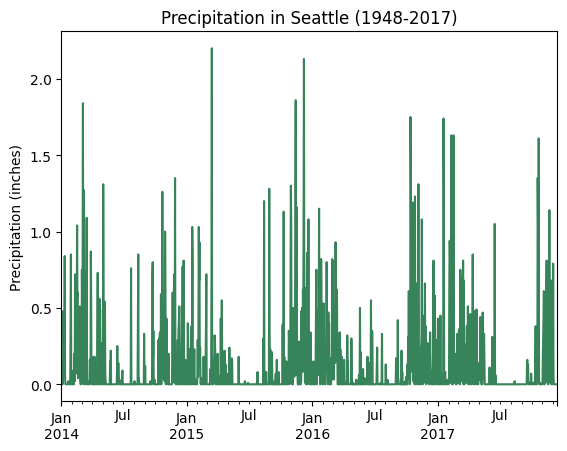

In [ ]:
plot_data = weather_df[weather_df['year'] >= 2014]
visualize(plot_data,
          title='Precipitation in Seattle (1948-2017)',
          xlabel=None,
          ylabel='Precipitation (inches)',
          legend_values=None,
          plot_type='pandas',
          save_plot=True,
          save_path='output.png',
          dpi=dpi_value,
          x='date',
          y='prcp',
          color=washington_colors[0],
          legend=False);

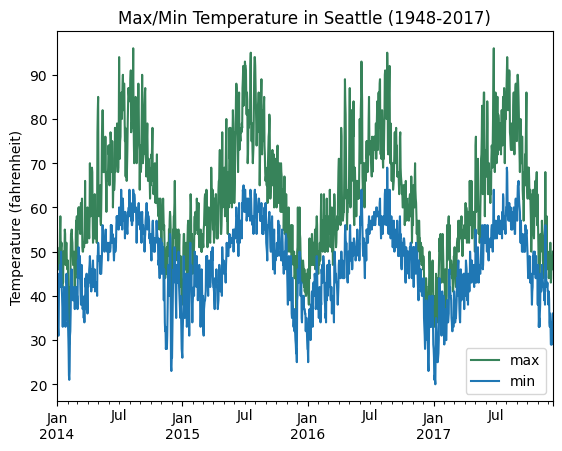

In [ ]:
visualize(plot_data,
          title='Max/Min Temperature in Seattle (1948-2017)',
          xlabel=None,
          ylabel='Temperature (fahrenheit)',
          legend_values=['max', 'min'],
          plot_type='pandas',
          save_plot=True,
          save_path='output2.png',
          dpi=dpi_value,
          x='date',
          y=['tmax', 'tmin'],
          color=washington_colors,
          legend=False);

### Rain Frequency Analysis:

1. **Frequency of Rainfall in Seattle:**
   
   To determine the frequency of rainfall in Seattle, we can analyze the 'rain' column in our dataset, which indicates whether it rained on a given day or not. By calculating the proportion of days with rain over the entire period of our dataset, we can determine how often it rains in Seattle on average. This analysis will provide insight into the typical occurrence of rainfall in the region.

In [ ]:
proportion_df = pd.DataFrame(weather_df['rain'].value_counts() / weather_df.shape[0]).reset_index()
proportion_df = proportion_df.rename(columns={'index': 'rain', 'rain': 'proportion'})
proportion_df['rain'] = np.where(proportion_df['rain'], 'Rain', 'No rain')

Seattle experienced rain on 43% of the days between 1948 and 2017, equating to roughly 157 days annually on average.


In [ ]:
proportion_df

,rain,proportion
0,No rain,0.573285
1,Rain,0.426598


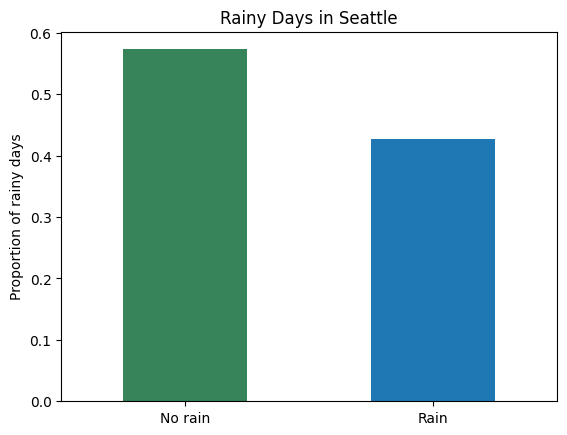

In [ ]:
visualize(proportion_df,
          title='Rainy Days in Seattle',
          xlabel=None,
          ylabel='Proportion of rainy days',
          legend_values=None,
          plot_type='pandas',
          save_plot=True,
          save_path='output3.png',
          dpi=dpi_value,
          x='rain',
          y='proportion',
          kind='bar',
          rot=0,
          color=washington_colors,
          legend=False);

How does this compare with rainfall patterns across the rest of the United States?

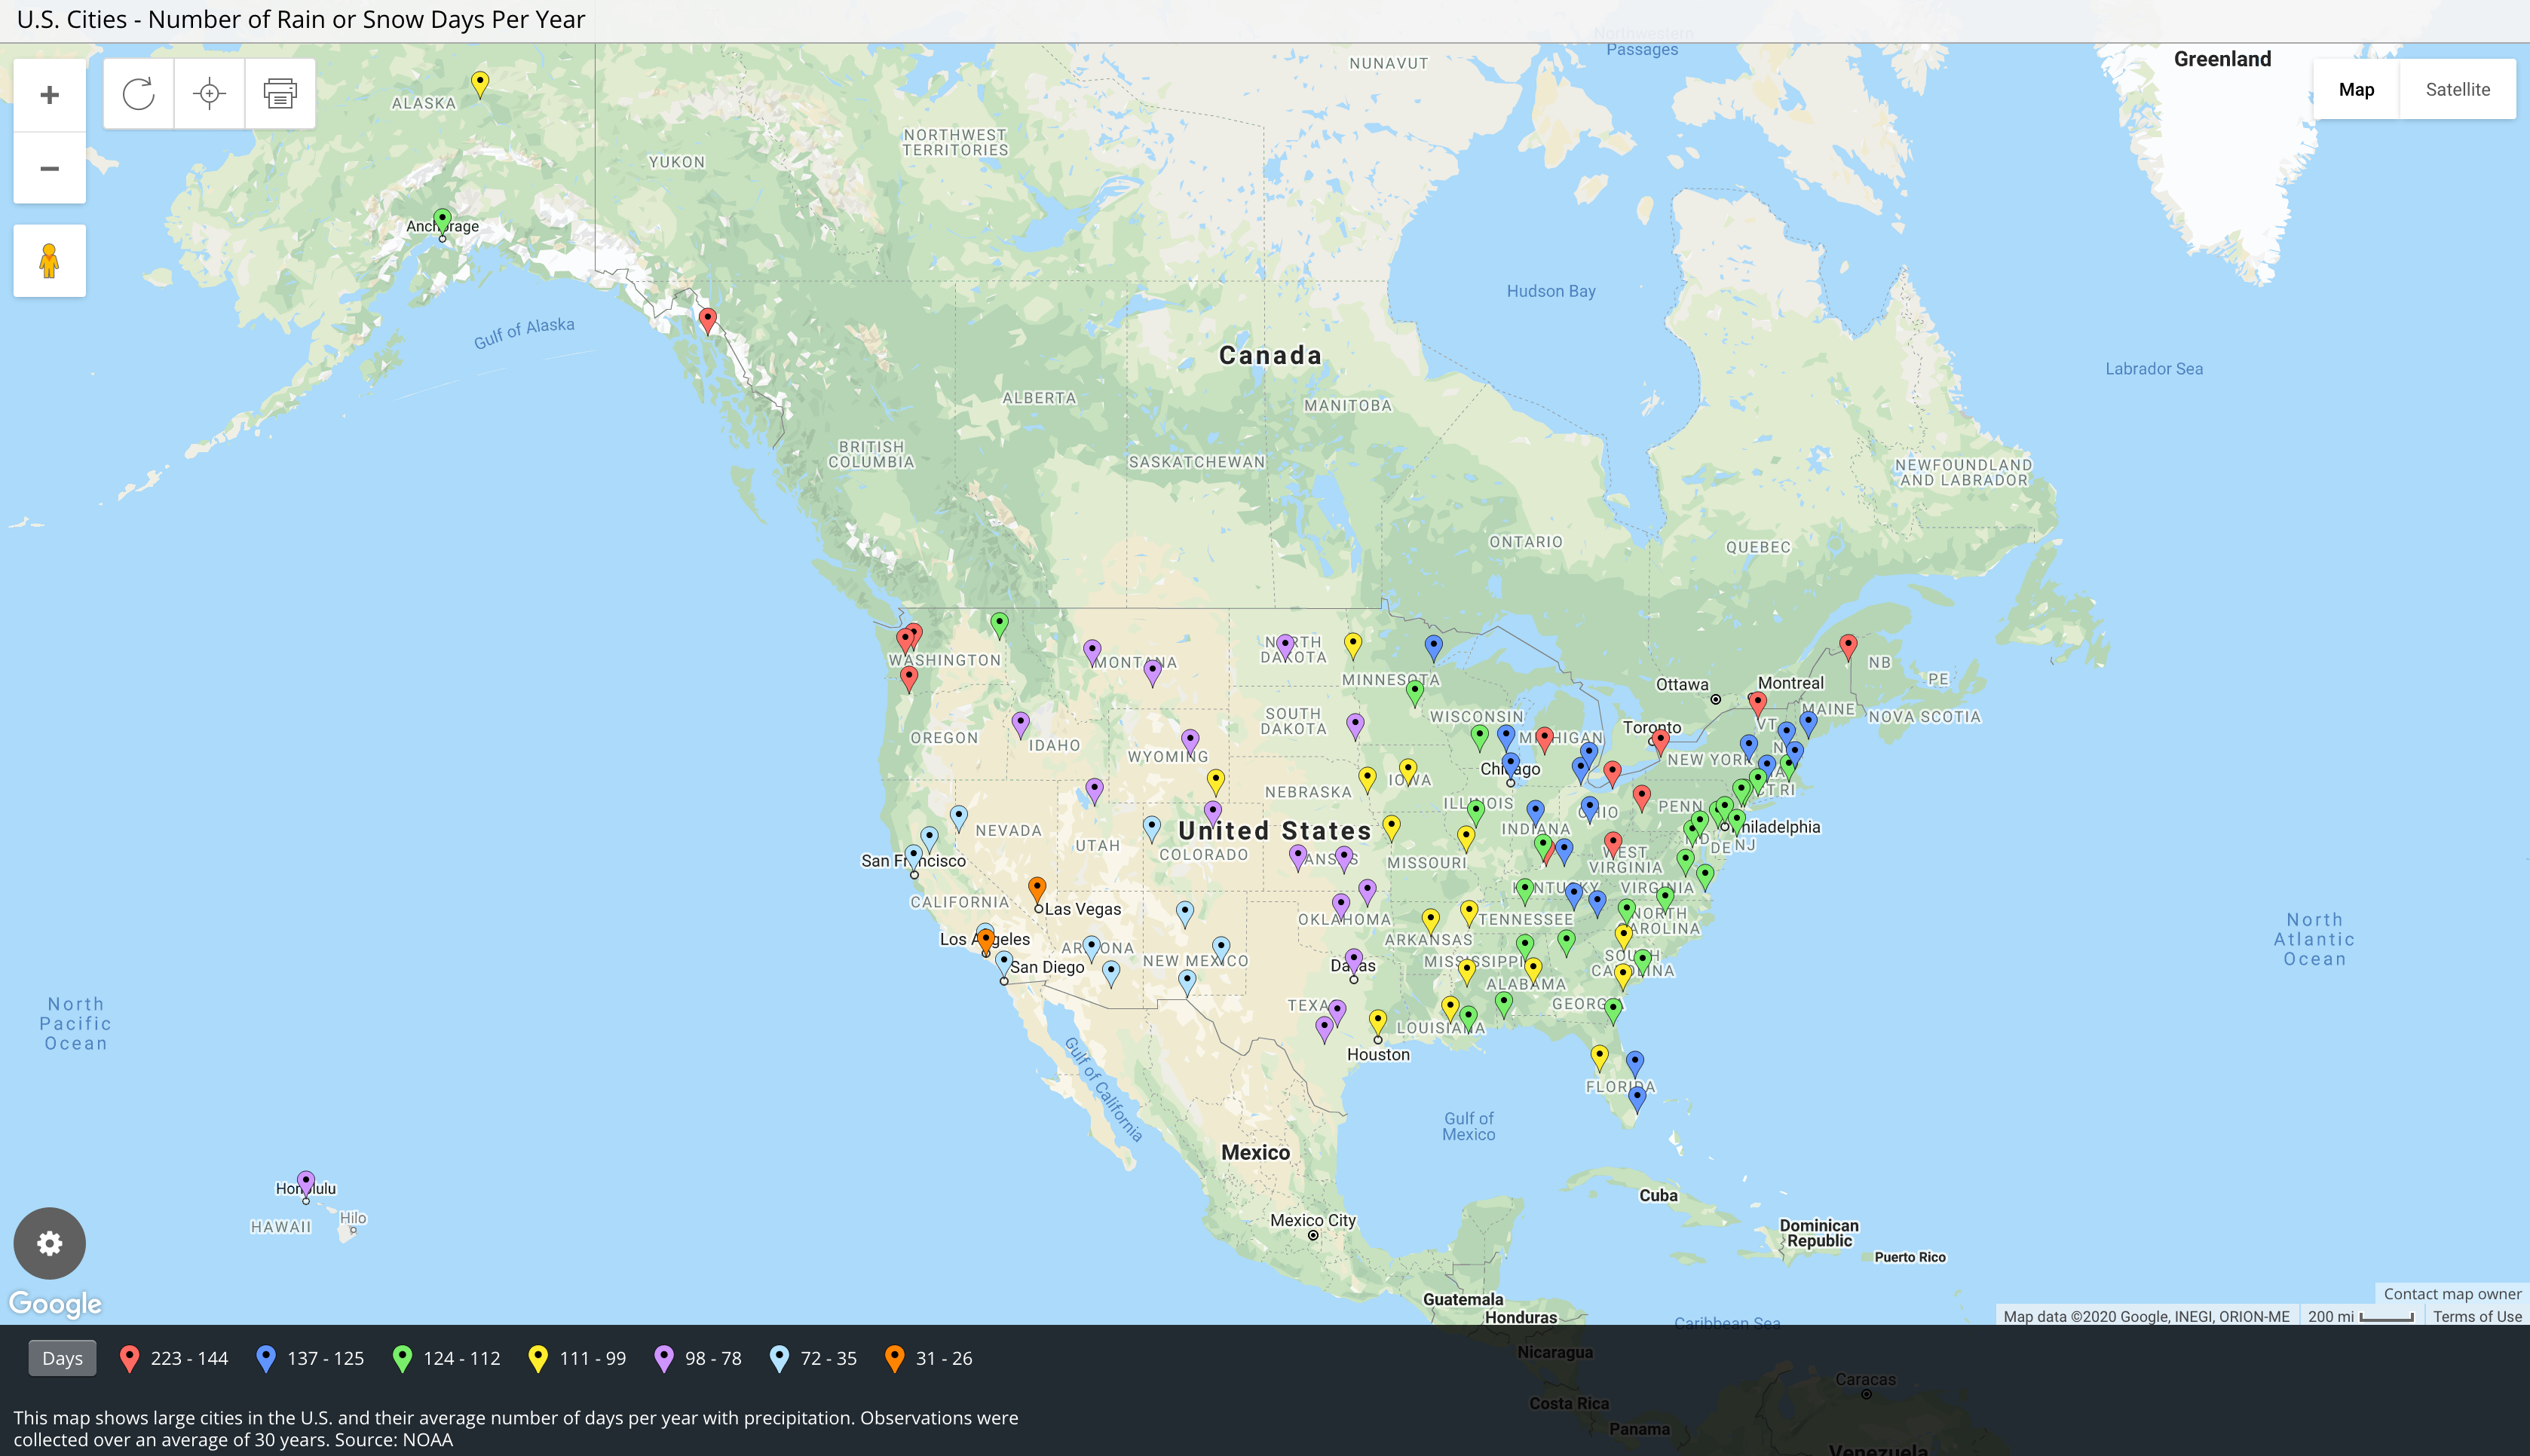

In [ ]:
from IPython.display import Image
Image('national_rainfall.png')

In Washington, depicted in red on the map, rainfall occurs for approximately 144-223 days annually. Our analysis reveals an average of about 153 rainy days per year from 1948 to 2017. Additionally, there are some states or regions in the northeast that share similar rainfall patterns to Seattle. The majority of states typically experience rainfall ranging between 78 and 137 days per year.


###Yearly Rainfall Frequency

The preceding graph illustrates the average rainfall data spanning from 1948 to 2017. I'm interested in whether there are significant variations in the proportion of rainy days over time.

In [ ]:
rain_by_year_df = weather_df[['year', 'rain']].groupby(['year', 'rain']).size().unstack(fill_value=0).reset_index()
rain_by_year_df = rain_by_year_df.assign(total=rain_by_year_df[False] + rain_by_year_df[True])
rain_by_year_df = rain_by_year_df.assign(rain_proportion = rain_by_year_df[True] / rain_by_year_df.total).drop([False, True, 'total'], axis=1).set_index('year')
rain_by_year_mean = rain_by_year_df.rain_proportion.mean()
rain_by_year_df.head()

rain,rain_proportion
year,
1948,0.483607
1949,0.380822
1950,0.531507
1951,0.410959
1952,0.379781


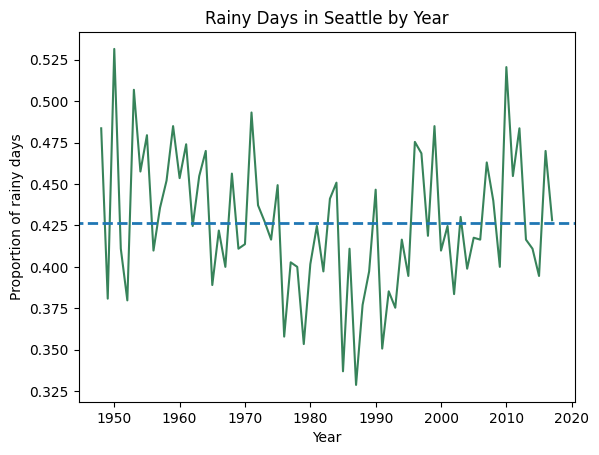

In [ ]:
visualize(rain_by_year_df,
          title='Rainy Days in Seattle by Year',
          xlabel='Year',
          ylabel='Proportion of rainy days',
          legend_values=None,
          mean_value=rain_by_year_mean,
          mean_line_color=washington_colors[1],
          plot_type='pandas',
          save_plot=True,
          save_path='output4.png',
          dpi=dpi_value,
          kind='line',
          rot=0,
          color=washington_colors[0],
          legend=False);

### Monthly Rainfall Frequency

Before delving into the frequency of rainy days by month, let's consider our expectations. Having spent considerable time in Florida, I'm accustomed to anticipating rain during the summer through the fall, coinciding with hurricane season. However, Seattle might not adhere to similar patterns, given its location in a mountainous region rather than a tropical setting like Florida. Despite not being an expert in weather or geology, let's examine the data to discern any trends.


In [ ]:
# create months_dict to convert month numbers to strings
def convert_month(month):
    '''
    Convert numeric month value to string representation

    :param month: int value representing month

    :return: month string representation
    '''

    months_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar',
                   4: 'Apr', 5: 'May', 6: 'Jun',
                   7: 'Jul', 8: 'Aug', 9: 'Sep',
                   10: 'Oct', 11: 'Nov', 12: 'Dec'}

    return months_dict[month]

In [ ]:
rain_by_month_prop = weather_df[['month', 'rain']].groupby(['month', 'rain']).size().unstack(fill_value=0).reset_index()
rain_by_month_prop = rain_by_month_prop.assign(total = rain_by_month_prop[False] + rain_by_month_prop[True])
rain_by_month_prop = rain_by_month_prop.assign(rain_proportion = rain_by_month_prop[True] / rain_by_month_prop.total)
rain_by_month_prop = rain_by_month_prop.drop([True, False, 'total'], axis=1)
rain_by_month_prop.set_index(rain_by_month_prop.month.apply(convert_month), inplace=True)
rain_by_month_prop.drop('month', axis=1, inplace=True)

In [ ]:
rain_by_month_prop

rain,rain_proportion
month,
Jan,0.598157
Feb,0.557634
Mar,0.558525
Apr,0.475238
May,0.355300
Jun,0.301239
Jul,0.158065
Aug,0.190323
Sep,0.290138


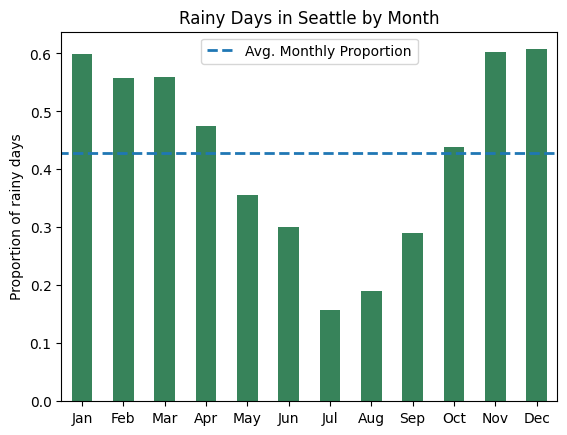

In [ ]:
visualize(rain_by_month_prop,
          title='Rainy Days in Seattle by Month',
          xlabel=None,
          ylabel='Proportion of rainy days',
          legend_values=['Avg. Monthly Proportion'],
          mean_value=rain_by_month_prop.rain_proportion.mean(),
          mean_line_color=washington_colors[1],
          plot_type='pandas',
          save_plot=True,
          save_path='output5.png',
          dpi=dpi_value,
          kind='bar',
          rot=0,
          color=washington_colors[0],
          legend=False);

***2. How much rainfall does Seattle receive?***

From our previous analysis, we discovered that rainy days, defined as any amount of rain occurring in a day, are least frequent during the summer months in Seattle. In this section, we will delve deeper into exploring the trends in actual rainfall over the years and months.

In [ ]:
monthly_mean = weather_df[['month', 'prcp', 'tmax', 'tmin']].groupby(['month']).mean().reset_index()
monthly_mean.set_index(monthly_mean.month.apply(convert_month), inplace=True)
monthly_mean.drop('month', axis=1, inplace=True)
monthly_mean

,prcp,tmax,tmin
month,,,
Jan,0.183055,45.131797,35.208756
Feb,0.143023,48.994944,36.787664
Mar,0.127963,52.321659,38.393548
Apr,0.088505,57.521905,41.460952
May,0.058502,64.309217,46.733180
Jun,0.048522,69.653333,51.628571
Jul,0.023106,75.497696,55.005530
Aug,0.034968,75.233180,55.317512
Sep,0.059057,69.631905,51.754286


The mean precipitation plot exhibits a similar U-shape pattern to the rainy days plot, indicating that more rainfall occurs in the winter months, while the least amount falls during the summer. Now, let's explore if temperature data offers any additional insights.

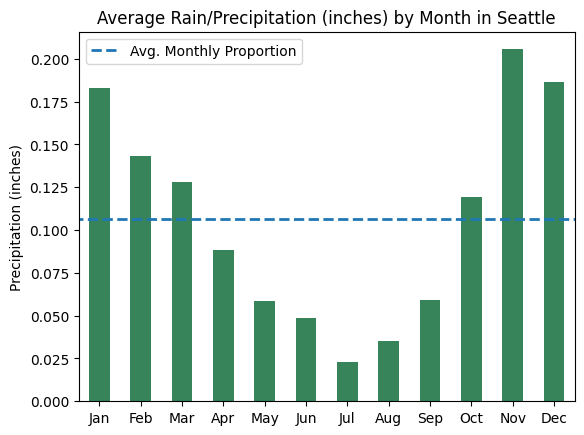

In [ ]:
visualize(monthly_mean[['prcp']],
          title='Average Rain/Precipitation (inches) by Month in Seattle',
          xlabel=None,
          ylabel='Precipitation (inches)',
          legend_values=['Avg. Monthly Proportion'],
          mean_value=monthly_mean.prcp.mean(),
          mean_line_color=washington_colors[1],
          plot_type='pandas',
          save_plot=True,
          save_path='output6.png',
          dpi=dpi_value,
          kind='bar',
          rot=0,
          color=washington_colors[0],
          legend=False);

In Seattle, higher temperatures during the summer months correspond to less rainfall, contrary to the expectation of increased humidity and rain. Next, we'll examine the temperature ranges for each month.

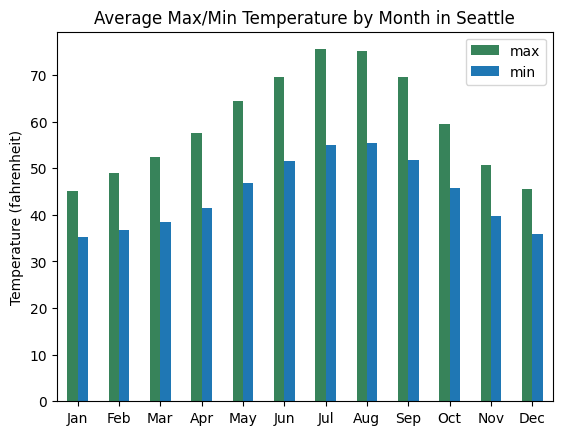

In [ ]:
visualize(monthly_mean[['tmax', 'tmin']],
          title='Average Max/Min Temperature by Month in Seattle',
          xlabel=None,
          ylabel='Temperature (fahrenheit)',
          legend_values=['max', 'min'],
          plot_type='pandas',
          save_plot=True,
          save_path='output7.png',
          dpi=dpi_value,
          kind='bar',
          rot=0,
          color=washington_colors,
          legend=False);

In [ ]:
temp_ranges = monthly_mean.tmax - monthly_mean.tmin
temp_ranges.index = monthly_mean.index

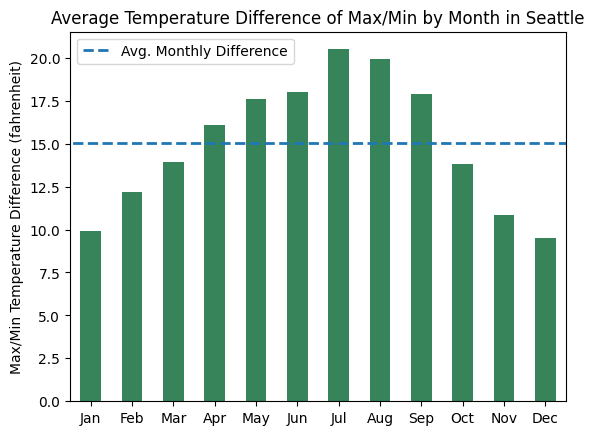

In [ ]:
plot_data = monthly_mean[['tmax', 'tmin']].assign(max_min_gap = temp_ranges)['max_min_gap']

visualize(plot_data,
          title='Average Temperature Difference of Max/Min by Month in Seattle',
          xlabel=None,
          ylabel='Max/Min Temperature Difference (fahrenheit)',
          mean_value=temp_ranges.mean(),
          mean_line_color=washington_colors[1],
          legend_values=['Avg. Monthly Difference'],
          plot_type='pandas',
          save_plot=True,
          save_path='output8.png',
          dpi=dpi_value,
          kind='bar',
          rot=0,
          color=washington_colors[0],
          legend=False);

***3. Seasonal Rain Trends in Seattle***

Our exploration reveals distinct seasonal patterns: rain is prominent during winter, while summers typically experience minimal rainfall. Seattle's warm and dry summers can be attributed to specific meteorological factors.

***5. Predicting Rain in Seattle***

Can we predict rainfall in Seattle? While our analysis highlights correlations between rainy days, time of year, and temperature, we haven't examined lag features yet. Let's explore simple lag features and leverage them to address the binary classification problem: predicting whether it will rain on a given day in Seattle.

Here's a concise overview of our lag features:

In [ ]:
weather_lag_df = weather_df.assign(tmin_lag1 = weather_df.tmin.shift(1),
                                   tmin_lag2 = weather_df.tmin.shift(2),
                                   tmin_lag3 = weather_df.tmin.shift(3),
                                   tmax_lag1 = weather_df.tmax.shift(1),
                                   tmax_lag2 = weather_df.tmax.shift(2),
                                   tmax_lag3 = weather_df.tmax.shift(3),
                                   prcp_lag1 = weather_df.prcp.shift(1),
                                   prcp_lag2 = weather_df.prcp.shift(2),
                                   prcp_lag3 = weather_df.prcp.shift(3))

In [ ]:
weather_lag_df = weather_lag_df.dropna().drop(['prcp', 'tmax', 'tmin'], axis=1)
weather_lag_df.head()

,date,year,month,day,rain,tmin_lag1,tmin_lag2,tmin_lag3,tmax_lag1,tmax_lag2,tmax_lag3,prcp_lag1,prcp_lag2,prcp_lag3
3,1948-01-04,1948,1,4,True,35.0,36.0,42.0,45.0,45.0,51.0,0.42,0.59,0.47
4,1948-01-05,1948,1,5,True,34.0,35.0,36.0,45.0,45.0,45.0,0.31,0.42,0.59
5,1948-01-06,1948,1,6,True,32.0,34.0,35.0,45.0,45.0,45.0,0.17,0.31,0.42
6,1948-01-07,1948,1,7,True,39.0,32.0,34.0,48.0,45.0,45.0,0.44,0.17,0.31
7,1948-01-08,1948,1,8,True,40.0,39.0,32.0,50.0,48.0,45.0,0.41,0.44,0.17


In [ ]:
plot_data = weather_lag_df.iloc[random.sample(list(weather_lag_df.reset_index().index), 1500)].copy()
plot_data.loc[:, 'rain'] = np.where(plot_data.loc[:, 'rain'], 'rain', 'no rain')

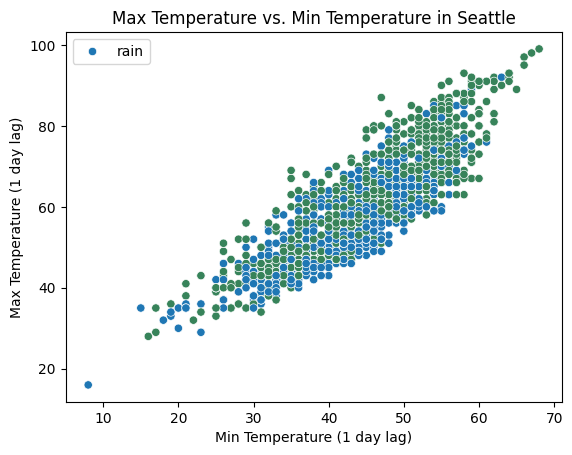

In [ ]:
visualize(plot_data,
          title='Max Temperature vs. Min Temperature in Seattle',
          xlabel='Min Temperature (1 day lag)',
          ylabel='Max Temperature (1 day lag)',
          plot_type='seaborn',
          seaborn_plot_type='scatter',
          save_plot=True,
          save_path='output9.png',
          dpi=dpi_value,
          x='tmin_lag1',
          y='tmax_lag1',
          hue='rain',
          palette=washington_colors);

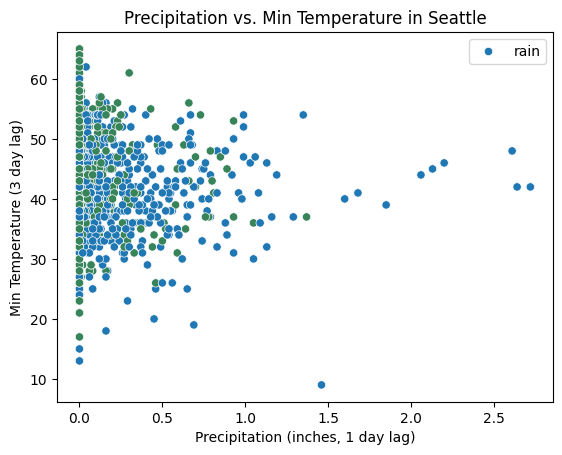

In [ ]:
visualize(plot_data,
          title='Precipitation vs. Min Temperature in Seattle',
          xlabel='Precipitation (inches, 1 day lag)',
          ylabel='Min Temperature (3 day lag)',
          plot_type='seaborn',
          seaborn_plot_type='scatter',
          save_plot=True,
          save_path='output10.png',
          dpi=dpi_value,
          x='prcp_lag1',
          y='tmin_lag3',
          hue='rain',
          palette=washington_colors);

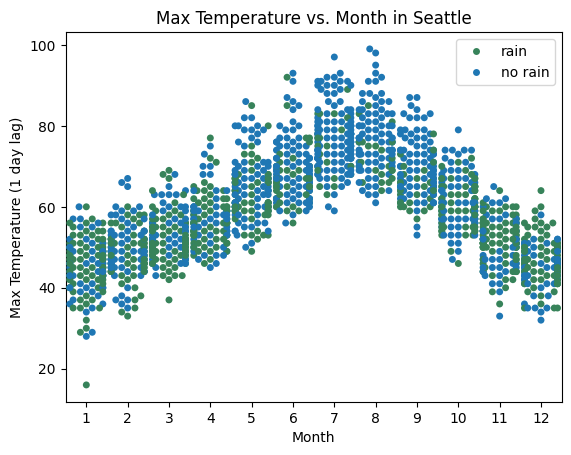

In [ ]:
visualize(plot_data,
          title='Max Temperature vs. Month in Seattle',
          xlabel='Month',
          ylabel='Max Temperature (1 day lag)',
          plot_type='seaborn',
          seaborn_plot_type='swarm',
          seaborn_legend='all',
          save_plot=True,
          save_path='output11.png',
          dpi=dpi_value,
          x='month',
          y='tmax_lag1',
          hue='rain',
          palette=washington_colors);

### Modeling

Utilized Random Forest for classification.

Training data: pre-1990; Validation: post-1990. Data scaled to prevent dominance of features. Employed suitable splitting method for dependent time series. Class frequencies reflect exploration findings.

In [ ]:
X = weather_lag_df[weather_lag_df['year'] < 1990].drop(['rain', 'year', 'date'], axis=1)
scaler = preprocessing.StandardScaler().fit(X)

X = scaler.transform(X)
y = weather_lag_df[weather_lag_df['year'] < 1990].loc[:, 'rain']
y = np.where(y, 'rain', 'no rain')
rain_count = collections.Counter(y)
rain_count = pd.DataFrame.from_dict(rain_count, orient='index').reset_index()
rain_count.columns = ['Weather', 'Days Count']
rain_count

,Weather,Days Count
0,rain,6530
1,no rain,8808


In [ ]:
# Split our data for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# create a dictionary of parameters
param_grid = {'n_estimators': [100, 250, 500, 1000], 'max_depth': [3, 5, 10, 15, 20],
              "max_features": [1, 3, 5]}

# create random forest model
rf_obj = RandomForestClassifier()

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# Create gridsearch object with various combinations of parameters
rf_grid = GridSearchCV(rf_obj, param_grid, cv=tscv,
                       scoring=scoring, n_jobs=-1, verbose=0,
                       refit='AUC', return_train_score=True)

In [37]:
%%time
rf_grid.fit(X, y)

CPU times: user 11.8 s, sys: 1.43 s, total: 13.2 s
Wall time: 17min 41s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15, 20],
                         'max_features': [1, 3, 5],
                         'n_estimators': [100, 250, 500, 1000]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

We have cross validation results.

Now let's check the optimal value for parameters.

In [38]:
results = rf_grid.cv_results_
train_res = pd.DataFrame({'data': 'train', 'auc': results['mean_train_AUC']})
test_res = pd.DataFrame({'data': 'test', 'auc': results['mean_test_AUC']})
max_depth_df = pd.DataFrame({'max_depth': results['param_max_depth']})
n_estimators_df = pd.DataFrame({'n_estimators': results['param_n_estimators']})
max_features_df = pd.DataFrame({'max_features': results['param_max_features']})
plot_model = pd.concat([pd.concat([train_res, test_res], axis=0),
                        pd.concat([max_depth_df, max_depth_df]),
                        pd.concat([n_estimators_df, n_estimators_df]),
                        pd.concat([max_features_df, max_features_df])], axis=1)
plot_model.head()

,data,auc,max_depth,n_estimators,max_features
0,train,0.753857,3,100,1
1,train,0.756326,3,250,1
2,train,0.755967,3,500,1
3,train,0.755945,3,1000,1
4,train,0.773096,3,100,3


The model starts overfitting as max_depth increases. According to sklearn documentation, an unlimited max depth allows the tree to fit the data perfectly, memorizing all patterns, including noise. This hinders achieving a better generalized result.


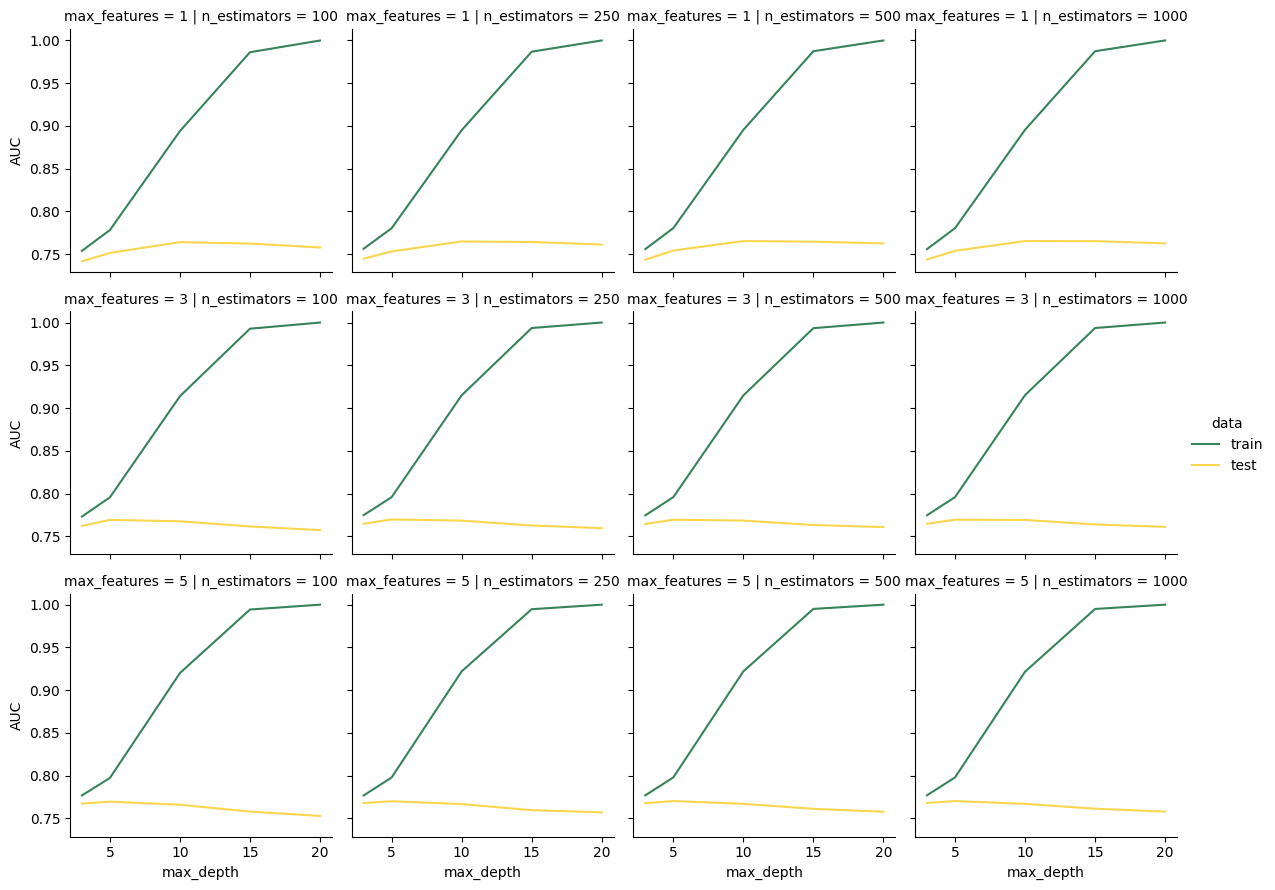

In [39]:
g = sns.FacetGrid(plot_model, col='n_estimators',  row='max_features', hue='data', palette=[washington_colors[0], '#fad64e'])
g.map(plt.plot, 'max_depth', 'auc').add_legend().set_axis_labels('max_depth', 'AUC')
g.savefig('output12.png', dpi=dpi_value)

In [40]:
best_params = rf_grid.best_params_
print(f'Grid search selected the following best parameters based on AUC: max_depth: {best_params["max_depth"]}, max_features: {best_params["max_features"]}, and n_estimators: {best_params["n_estimators"]}.')

Grid search selected the following best parameters based on AUC: max_depth: 5, max_features: 5, and n_estimators: 500.


Grid search determined the optimal parameters based on AUC to be: max_depth: 5, max_features: 5, and n_estimators: 1000.

In [41]:
rf_best_model = rf_grid.best_estimator_

Let's evaluate our cross-validation results using a holdout dataset.


In [42]:
X_holdout = weather_lag_df[weather_lag_df['year'] >= 1990].drop(['rain', 'year', 'date'], axis=1)
X_holdout = scaler.transform(X_holdout)
y_holdout = weather_lag_df[weather_lag_df['year'] >= 1990].loc[:, 'rain']
y_holdout = np.where(y_holdout, 1, 0)
rain_count = collections.Counter(y_holdout)
rain_count['No rain'] = rain_count.pop(0)
rain_count['Rain'] = rain_count.pop(1)
rain_count = pd.DataFrame.from_dict(rain_count, orient='index').reset_index()
rain_count.columns = ['Weather', 'Days Count']
rain_count

,Weather,Days Count
0,No rain,5834
1,Rain,4367


In [43]:
from matplotlib.colors import LinearSegmentedColormap

boundaries = [0.0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]  # custom boundaries

# here I generated twice as many colors,
# so that I could prune the boundaries more clearly
hex_colors = sns.light_palette(washington_colors[0], n_colors=len(boundaries) * 2 + 2, as_cmap=False).as_hex()
hex_colors = [hex_colors[i] for i in range(0, len(hex_colors), 2)]

colors=list(zip(boundaries, hex_colors))

custom_color_map = LinearSegmentedColormap.from_list(
    name='custom_navy',
    colors=colors,
)

The metrics below were derived from the holdout data (from the year 1990 onwards). Results are satisfactory for a simple model with limited features. The model achieves an accuracy of approximately 72%, compared to the baseline expectation of rain occurring 43% of the time in Seattle. This performance surpasses the naive decision to predict rain or no rain every day.

Furthermore, the model demonstrates a reasonable ability to identify rainy days, with a recall rate of 81%. By default, the classification of rain or no rain is based on the maximum probability. Adjusting the probability cutoff for classifying a rainy day could enhance either the capture of rainy days or precision, but this exploration is deferred for future analysis.

              precision    recall  f1-score   support

        rain       0.74      0.80      0.77      5834
     no rain       0.70      0.61      0.65      4367

    accuracy                           0.72     10201
   macro avg       0.72      0.71      0.71     10201
weighted avg       0.72      0.72      0.72     10201



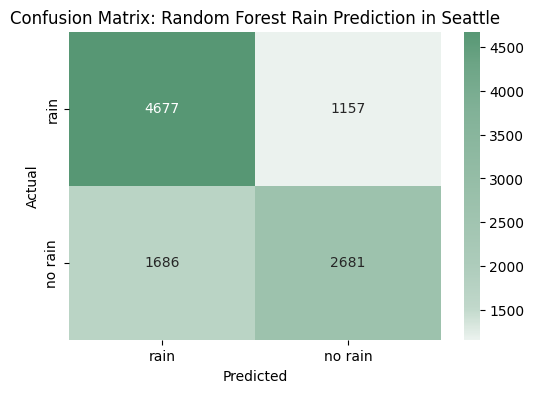

In [44]:
y_test_pred = np.where(rf_best_model.predict(X_holdout) == 'rain', 1, 0)
labels_df = pd.DataFrame({'rain': y_holdout})
labels = labels_df.drop_duplicates(
).sort_values('rain')
labels = labels.assign(label=['rain', 'no rain'])

conf_mat = metrics.confusion_matrix(y_true=y_holdout, y_pred=y_test_pred)
fig, ax = plt.subplots(figsize=(6, 4))
plot = sns.heatmap(conf_mat, annot=True, fmt="d",
                   xticklabels=labels.label.values,
                   yticklabels=labels.label.values,
                   cmap=custom_color_map)
plot.set(title='Confusion Matrix: Random Forest Rain Prediction in Seattle',
         xlabel='Predicted',
         ylabel='Actual')
fig = plot.get_figure()
fig.savefig('output13.png', dpi=dpi_value)

print(metrics.classification_report(y_holdout, y_test_pred, target_names=labels.label.values))

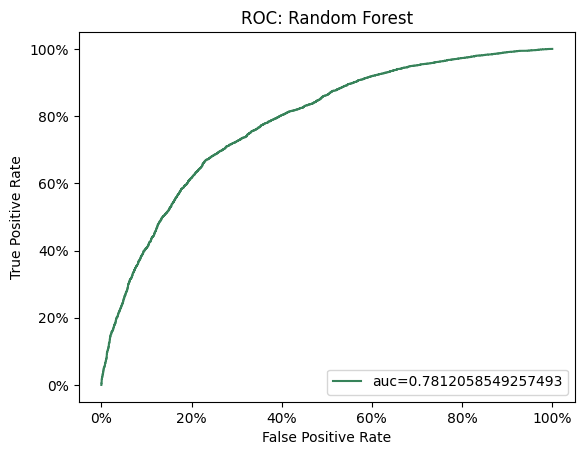

In [45]:
logistic_scores = rf_best_model.predict_proba(X_holdout)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_holdout, logistic_scores)
auc = metrics.roc_auc_score(y_holdout, logistic_scores)
auc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
plot = auc_data.plot(x='fpr', y='tpr', label="auc=" + str(auc), color=washington_colors[0])
vals = plot.get_xticks()
plot.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
vals = plot.get_yticks()
plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title('ROC: Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.savefig('output14.png', dpi=dpi_value)
plt.show()

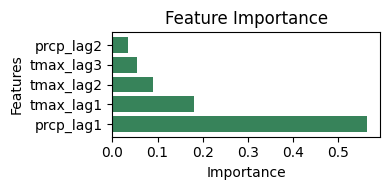

In [46]:
importances = rf_best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
headers = ["name", "score"]
values_rf = sorted(zip(weather_lag_df.drop(['rain', 'year', 'date'], axis=1).columns, importances), key=lambda x: x[1] * -1)
# print(tabulate(values_rf[0:10], headers, tablefmt="plain"))

# Plot the feature importances of the forest
plt.rcdefaults()
plt.figure(figsize=[4, 2])
plt.barh(pd.DataFrame(values_rf[0:5]).iloc[:, 0], importances[indices][0:5], align='center', color=washington_colors[0])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('output15.png', dpi=dpi_value)
plt.show()